In [1]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np

df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding='latin-1')

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '')
    .str.replace(')', '')
)

cols_to_drop = ['customer_email', 'customer_password', 'product_image']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

date_cols = [col for col in df.columns if 'date' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['shipping_delay_days'] = df['days_for_shipping_real'] - df['days_for_shipment_scheduled']
df['order_year'] = df['order_date_dateorders'].dt.year
df['order_day_of_week'] = df['order_date_dateorders'].dt.day_name()
df['profit_margin_pct'] = np.where(
    df['sales'] != 0,
    (df['order_profit_per_order'] / df['sales'] * 100).round(2),
    0
)

print(f"Loaded and cleaned: {df.shape[0]:,} rows x {df.shape[1]} columns")

Saving tokenized_access_logs.csv to tokenized_access_logs.csv
Saving DescriptionDataCoSupplyChain.csv to DescriptionDataCoSupplyChain.csv
Saving DataCoSupplyChainDataset.csv to DataCoSupplyChainDataset.csv
Loaded and cleaned: 180,519 rows x 54 columns


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All ML libraries loaded.")

All ML libraries loaded.


In [3]:
feature_cols = [
    'days_for_shipment_scheduled', 'order_item_quantity',
    'sales', 'order_item_discount', 'order_profit_per_order',
    'product_price', 'benefit_per_order'
]

cat_cols = ['shipping_mode', 'market', 'type', 'category_name', 'order_status']

df_model = df[feature_cols + cat_cols + ['late_delivery_risk']].copy()
df_model = df_model.dropna()

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

X = df_model.drop('late_delivery_risk', axis=1)
y = df_model['late_delivery_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")
print(f"Late delivery rate: {y.mean()*100:.1f}%")

Training set: 144,415 rows
Test set: 36,104 rows
Late delivery rate: 54.8%


In [4]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_prob,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    print(f"{name}: Accuracy={results[name]['accuracy']:.4f} | ROC-AUC={results[name]['roc_auc']:.4f}")

Logistic Regression: Accuracy=0.6892 | ROC-AUC=0.7211
Random Forest: Accuracy=0.6701 | ROC-AUC=0.7511
Gradient Boosting: Accuracy=0.7078 | ROC-AUC=0.7698


In [5]:
comparison = pd.DataFrame({
    name: {
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1'],
        'ROC-AUC': r['roc_auc']
    }
    for name, r in results.items()
}).T.round(4)

print("MODEL COMPARISON — Late Delivery Prediction")
comparison

MODEL COMPARISON — Late Delivery Prediction


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.6892,0.8011,0.5762,0.6703,0.7211
Random Forest,0.6701,0.7147,0.6631,0.6880,0.7511
Gradient Boosting,0.7078,0.8825,0.5389,0.6692,0.7698


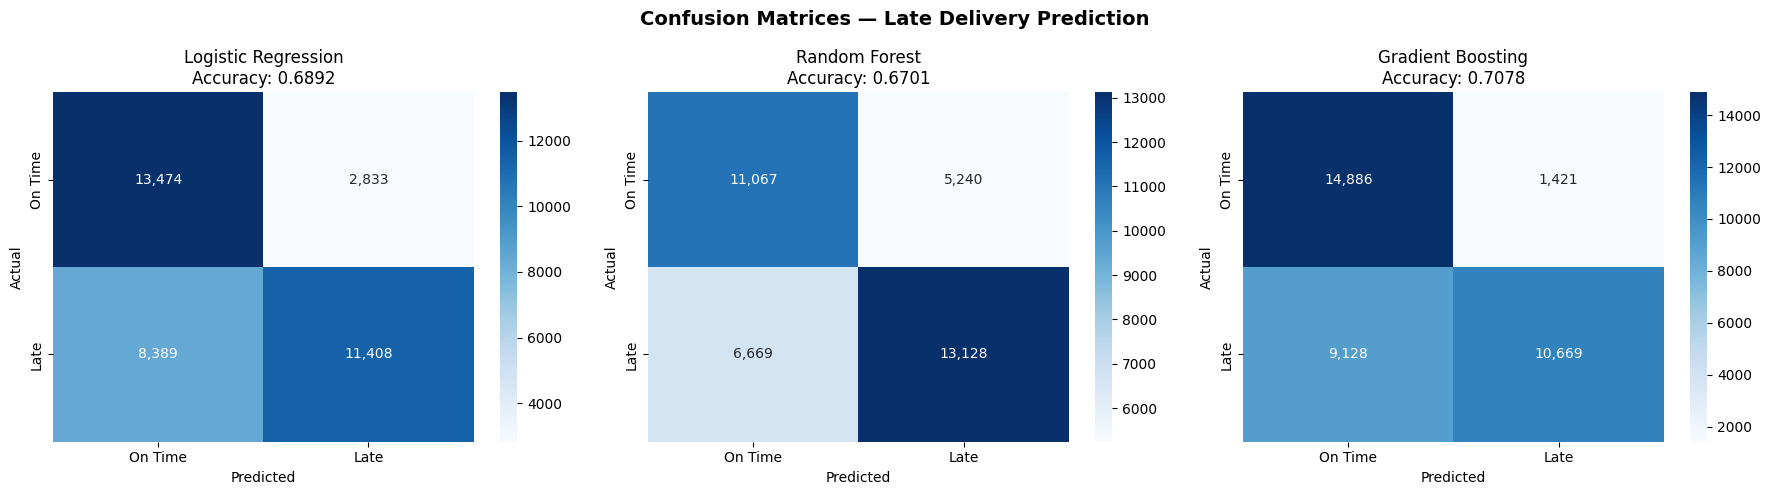

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, r) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, r['predictions'])
    sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', ax=ax,
                xticklabels=['On Time', 'Late'], yticklabels=['On Time', 'Late'])
    ax.set_title(f'{name}\nAccuracy: {r["accuracy"]:.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices — Late Delivery Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

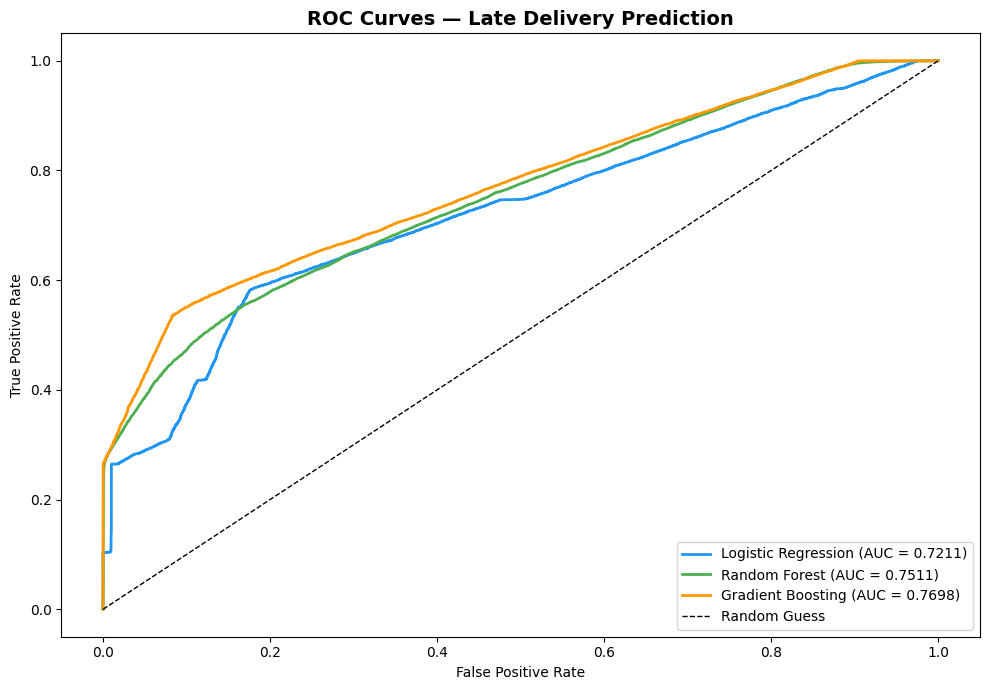

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#2196F3', '#4CAF50', '#FF9800']

for (name, r), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, r['probabilities'])
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {r["roc_auc"]:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')
ax.set_title('ROC Curves — Late Delivery Prediction', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

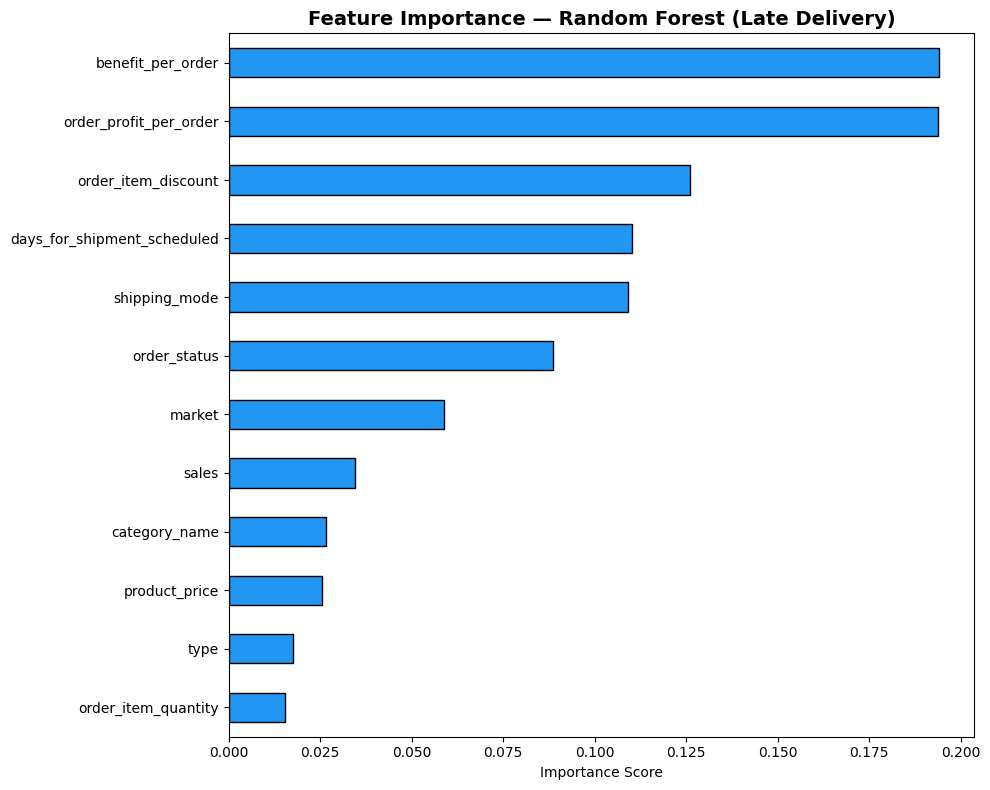

In [8]:
rf_model = results['Random Forest']['model']
importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
importance.plot(kind='barh', ax=ax, color='#2196F3', edgecolor='black')
ax.set_title('Feature Importance — Random Forest (Late Delivery)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [9]:
df['is_fraud'] = (df['order_status'] == 'SUSPECTED_FRAUD').astype(int)

fraud_features = [
    'days_for_shipment_scheduled', 'days_for_shipping_real',
    'order_item_quantity', 'sales', 'order_item_discount',
    'order_profit_per_order', 'product_price', 'benefit_per_order',
    'late_delivery_risk', 'shipping_delay_days'
]

fraud_cat_cols = ['shipping_mode', 'market', 'type', 'category_name']

df_fraud = df[fraud_features + fraud_cat_cols + ['is_fraud']].copy()
df_fraud = df_fraud.dropna()

for col in fraud_cat_cols:
    le = LabelEncoder()
    df_fraud[col] = le.fit_transform(df_fraud[col].astype(str))

X_fraud = df_fraud.drop('is_fraud', axis=1)
y_fraud = df_fraud['is_fraud']

print(f"Fraud rate: {y_fraud.mean()*100:.2f}%")
print(f"Fraud cases: {y_fraud.sum():,} out of {len(y_fraud):,}")

Fraud rate: 2.25%
Fraud cases: 4,062 out of 180,519


In [10]:
!pip install imbalanced-learn -q

from imblearn.over_sampling import SMOTE

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_f, y_train_f)

print(f"Before SMOTE: {y_train_f.value_counts().to_dict()}")
print(f"After SMOTE: {pd.Series(y_train_balanced).value_counts().to_dict()}")

Before SMOTE: {0: 141165, 1: 3250}
After SMOTE: {0: 141165, 1: 141165}


In [11]:
fraud_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

fraud_results = {}
for name, model in fraud_models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_f)
    y_prob = model.predict_proba(X_test_f)[:, 1]

    fraud_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_prob,
        'accuracy': accuracy_score(y_test_f, y_pred),
        'precision': precision_score(y_test_f, y_pred),
        'recall': recall_score(y_test_f, y_pred),
        'f1': f1_score(y_test_f, y_pred),
        'roc_auc': roc_auc_score(y_test_f, y_prob)
    }
    print(f"{name}: Precision={fraud_results[name]['precision']:.4f} | Recall={fraud_results[name]['recall']:.4f} | ROC-AUC={fraud_results[name]['roc_auc']:.4f}")

Logistic Regression: Precision=0.1865 | Recall=0.8608 | ROC-AUC=0.9680
Random Forest: Precision=0.3296 | Recall=0.5111 | ROC-AUC=0.9571
Gradient Boosting: Precision=0.2005 | Recall=0.8190 | ROC-AUC=0.9668


In [12]:
fraud_comparison = pd.DataFrame({
    name: {
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1'],
        'ROC-AUC': r['roc_auc']
    }
    for name, r in fraud_results.items()
}).T.round(4)

print("MODEL COMPARISON — Fraud Detection")
fraud_comparison

MODEL COMPARISON — Fraud Detection


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.9124,0.1865,0.8608,0.3066,0.9680
Random Forest,0.9656,0.3296,0.5111,0.4008,0.9571
Gradient Boosting,0.9225,0.2005,0.8190,0.3221,0.9668


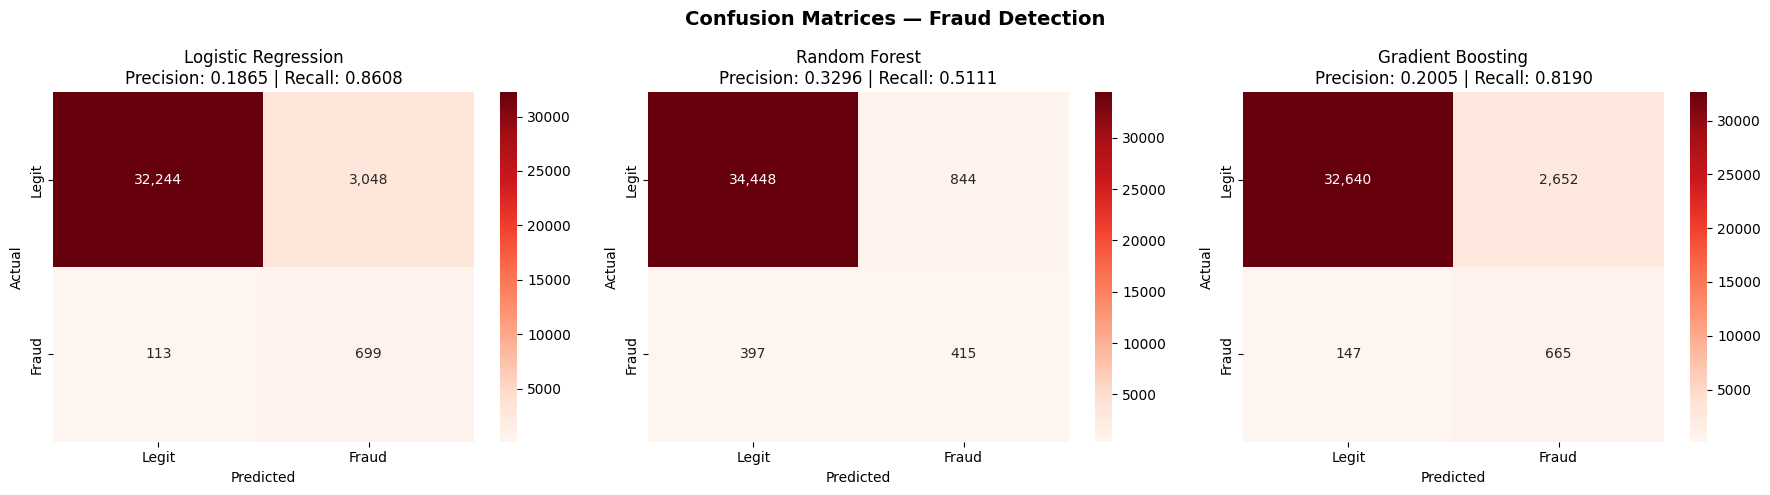

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, r) in zip(axes, fraud_results.items()):
    cm = confusion_matrix(y_test_f, r['predictions'])
    sns.heatmap(cm, annot=True, fmt=',', cmap='Reds', ax=ax,
                xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    ax.set_title(f'{name}\nPrecision: {r["precision"]:.4f} | Recall: {r["recall"]:.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices — Fraud Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

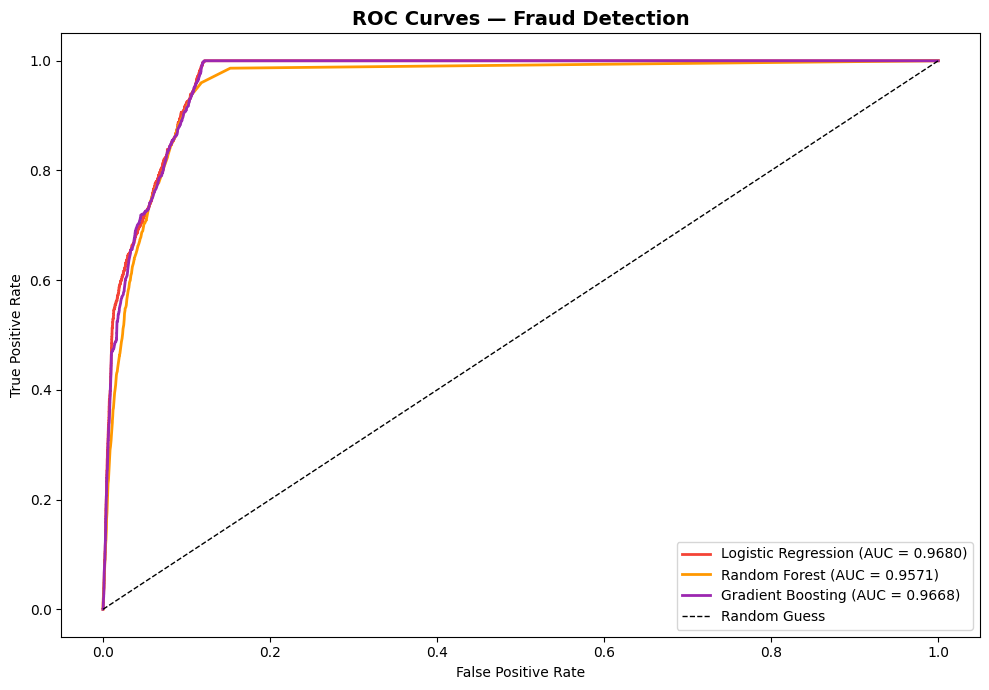

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#F44336', '#FF9800', '#9C27B0']

for (name, r), color in zip(fraud_results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test_f, r['probabilities'])
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {r["roc_auc"]:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')
ax.set_title('ROC Curves — Fraud Detection', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

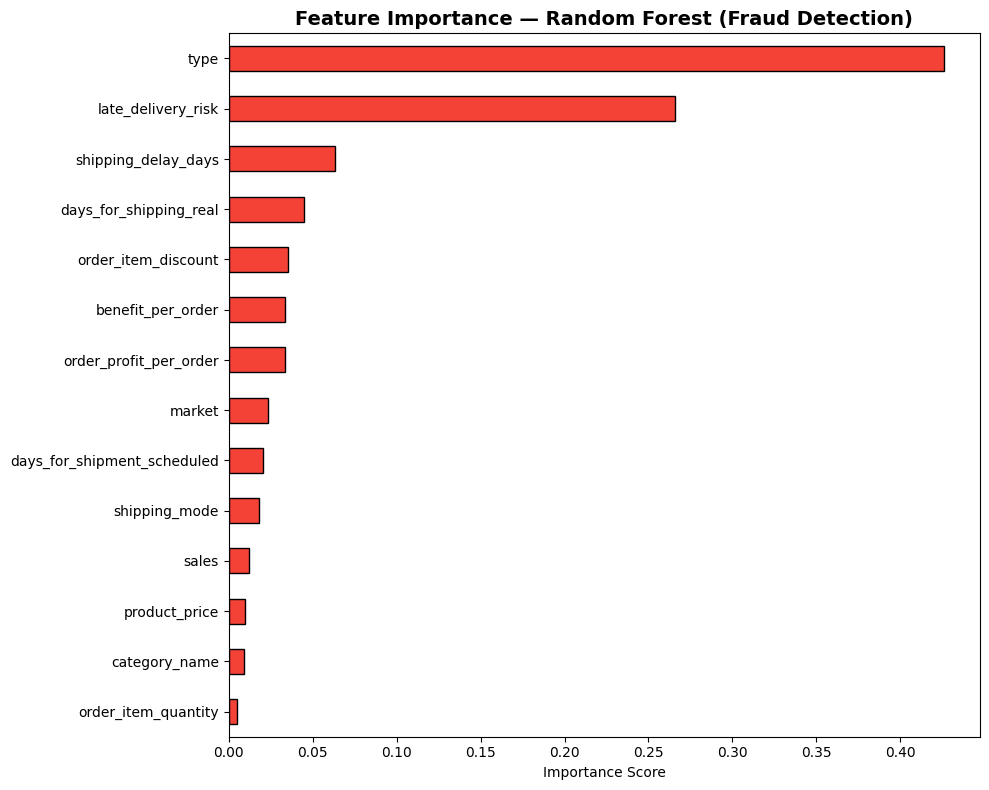

In [15]:
rf_fraud = fraud_results['Random Forest']['model']
importance_fraud = pd.Series(rf_fraud.feature_importances_, index=X_fraud.columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
importance_fraud.plot(kind='barh', ax=ax, color='#F44336', edgecolor='black')
ax.set_title('Feature Importance — Random Forest (Fraud Detection)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

---

# Deliverable 3: Predictive Modeling — Key Findings

## Model 1: Late Delivery Prediction
- **Goal:** Predict whether an order will arrive late based on order characteristics
- **Best Model:** [Fill in after running — whichever has highest ROC-AUC]
- **Top Predictive Features:** [Fill in from the feature importance chart]
- **Business Impact:** Enables proactive intervention on high-risk orders before they ship, improving on-time delivery rate from the current 45.2%

## Model 2: Fraud Detection
- **Goal:** Identify potentially fraudulent orders before they are fulfilled
- **Challenge:** Only 2.3% of orders are fraud — severe class imbalance handled using SMOTE oversampling
- **Best Model:** [Fill in after running — focus on recall since missing fraud is costly]
- **Top Fraud Indicators:** [Fill in from the feature importance chart]
- **Business Impact:** Flagging suspicious orders for review before shipping can prevent financial losses across 4,000+ suspected fraud cases

## Technical Approach
- Three algorithms compared: Logistic Regression, Random Forest, Gradient Boosting
- SMOTE applied to fraud detection to address 97.7% vs 2.3% class imbalance
- Models evaluated on accuracy, precision, recall, F1 score, and ROC-AUC
- Feature importance analysis identifies the key drivers behind predictions

## Recommendations
1. **Deploy Late Delivery Model** — Integrate the best-performing model into the order management system to flag at-risk orders at time of purchase
2. **Implement Fraud Screening** — Use the fraud model to create a review queue for orders exceeding a risk threshold before shipping
3. **Monitor and Retrain** — Models should be retrained quarterly as shipping patterns and fraud tactics evolve